# Simplest Implementation of Diffusion Models

We are going to implement the simplest possible version of diffusion models following the exposition of Ho 2020 ("Denoising Diffusion Probabilistic Models" http://arxiv.org/abs/2006.11239)

Generative models learn to generate new samples (e.g., images) starting from a latent variable following a tractable (i.e., simple) distribution.
Diffusion models do this by first establishing a simple way to transform samples from the distribution of interest (the images) to the tractable distribution, then training a neural network to reverse this process.
In this way, the network learns how to go back from the tractable distribution to the distribution of interest.

Diffusion refers to a gradual corruption of the training samples by repeatedly adding a small amount of noise.
After a few hundreds or thousands of steps, the noise overwhelms the information in the original sample, such that the result is indistinguishable from the simple distribution that we will use as a starting point to generate new samples.
Figure 2 from the paper (Ho, 2020) demonstrates this process graphically:

![diffusion](/images/diffusion/diffusion.png)

Here, $x_0$ is the original sample, the image of a guy, and the process of adding noise is represented by the dashed arrow going from right to left, so that, after $T$ steps, only noise remains in $x_T$.
The generative process is represented by the arrows going from left to right, from $x_T$ to $x_0$, and the generative model is denoted by $p_\theta$, while the noise-adding process is $q$.

In this tutorial, we will learn to generate samples from a very simple unidimensional distribution, so that we can easily visualize the generative process.
Let's start by generating some data:

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# import pandas as pd
import numpy as np
import torch
# import seaborn as sns
import itertools
from tqdm.auto import tqdm
plt.style.use('../Diablo.mplstyle')

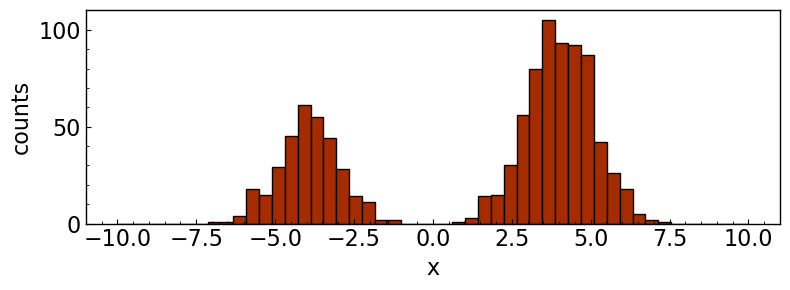

In [81]:
# data_distribution is a mix of two normal distributions
mix = torch.distributions.Categorical(torch.tensor([1, 2]))
dists = torch.distributions.Normal(torch.tensor([-4., 4.]), torch.tensor([1., 1.]))
data_distribution = torch.distributions.mixture_same_family.MixtureSameFamily(mix, dists)

dataset = data_distribution.sample(torch.Size([1000, 1]))
fig, ax = plt.subplots(figsize=(8,3))
bins = np.linspace(-10, 10, 50)
ax.hist(dataset[:, 0], bins=bins, edgecolor='black');
ax.set(xlabel='x', ylabel='counts');
fig.tight_layout()
fig.savefig('data_example.png')

This plot represents the data distribution, i.e., $q(x_0)$. As you can see, our training dataset contains samples from a mixture of two Gaussian distributions, where the component on the right is sampled twice as much frequently.

The forward diffusion process is in Equation 2 of the paper:

$$
q(x_{1:T}|x_0):=\prod_{t=1}^T q(x_t|x_{t-1})
$$

with each step adding Gaussian noise:

$$
q(x_t|x_{t-1}):=\mathcal{N}(x_t | \sqrt{1-\beta_t}x_{t-1} ; \beta_t I)
$$

The mean and variance of this distribution is chosen so that the end distribution of $x_T$ after the diffusion process is a zero-mean, unit-variance Gaussian, from which we can easily sample.

This process is easily implemented with a loop:

In [5]:
# we will keep these parameters fixed throughout
TIME_STEPS = 250
BETA = 0.02

In [6]:
def do_diffusion(data, steps=TIME_STEPS, beta=BETA):
    # perform diffusion following equation 2
    # returns a list of q(x(t)) and x(t)
    # starting from t=0 (i.e., the dataset)
    
    distributions, samples = [None], [data]
    xt = data
    for t in range(steps):
        q = torch.distributions.Normal(
            np.sqrt(1 - beta) * xt,
            np.sqrt(beta)
        )
        xt = q.sample()
        
        distributions.append(q)
        samples.append(xt)
    
    return distributions, samples

In [7]:
_, samples = do_diffusion(dataset)

We can visualize the diffusion process by plotting time on the $x$ axis, and the diffused samples on the $y$ axis:

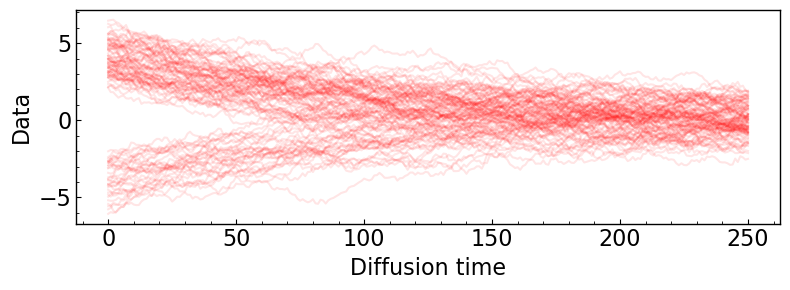

In [80]:
fig, ax = plt.subplots(figsize=(8,3))
for t in torch.stack(samples)[:, :, 0].T[:100]:
    ax.plot(t, c='red', alpha=0.1)
ax.set_xlabel('Diffusion time')
ax.set_ylabel('Data')
fig.tight_layout()
fig.savefig('Time_series.png')

As you can see, adding noise gradually transforms all samples into a Normal $\mathcal{N}(0,1)$ distribution. We are now ready to train a model to invert this process.

## Training

To keep things as simple as possible, here we use the loss in Equation 3 in the paper without any of the optimizations presented later, which only play a role for complex, real-world distributions.

The loss is an upper bound on the negative log likelihood:

$$
L := \mathbb{E}_q\left[
-\log p(x_T)
-\sum_{t=1}^T \log\frac{p_\theta(x_{t-1}|x_t)}{q(x_t|x_{t-1})}
\right]
$$

Where the generative model, also called *reverse process*, has form:

$$
p_\theta(x_{t-1}|x_t):=\mathcal{N}(x_{t-1} ; \mu_\theta(x_t,t), \Sigma_\theta(x_t, t))
$$

Note that we are training two neural networks, $\mu_\theta$ and $\Sigma_\theta$, which take as input a noisy sample $x_t$ and the step $t$, and try to predict the parameters of the distribution of the sample $x_{t-1}$ to which noise was added.

The loss is implemented in the function below.
This function requires the entire diffusion trajectory for the training samples, as well as the two neural networks that define the inverse process:

In [12]:
def compute_loss(forward_distributions, forward_samples, mean_model, var_model):
    # here we compute the loss in equation 3
    # forward = q , reverse = p
    
    # loss for x(T)
    p = torch.distributions.Normal(
            torch.zeros(forward_samples[0].shape),
            torch.ones(forward_samples[0].shape)
    )
    loss = -p.log_prob(forward_samples[-1]).mean()
        
    for t in range(1, len(forward_samples)):
        xt = forward_samples[t]         # x(t)
        xprev = forward_samples[t - 1]  # x(t-1)
        q = forward_distributions[t]    # q( x(t) | x(t-1) )
        
        # compute p( x(t-1) | x(t) ) as equation 1
        xin = torch.cat(
            (xt, t * torch.ones(xt.shape) / len(forward_samples)),
            dim=1
        )
        mu = mean_model(xin)
        sigma = var_model(xin)
        p = torch.distributions.Normal(mu, sigma)
        
        # add a term to the loss
        loss -= torch.mean(p.log_prob(xprev))
        loss += torch.mean(q.log_prob(xt))

        
    return loss / len(forward_samples)

Let us now define two very simple neural networks to predict the mean and variance:

In [13]:
mean_model = torch.nn.Sequential(
    torch.nn.Linear(2, 4), torch.nn.ReLU(), 
    torch.nn.Linear(4, 1)
)
var_model = torch.nn.Sequential(
    torch.nn.Linear(2, 4), torch.nn.ReLU(),
    torch.nn.Linear(4, 1), torch.nn.Softplus()
)

And let's train them:

In [14]:
optim = torch.optim.AdamW(
    itertools.chain(mean_model.parameters(), var_model.parameters()),
    lr=1e-2, weight_decay=1e-6,
)

In [22]:
loss_history = []
bar = tqdm(range(1000))
for e in bar:
    forward_distributions, forward_samples = do_diffusion(dataset)
    
    optim.zero_grad()
    loss = compute_loss(
        forward_distributions, forward_samples, mean_model, var_model
    )
    loss.backward()
    optim.step()
    
    bar.set_description(f'Loss: {loss.item():.4f}')
    loss_history.append(loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

We can make sure that the model has converged by inspecting the loss:

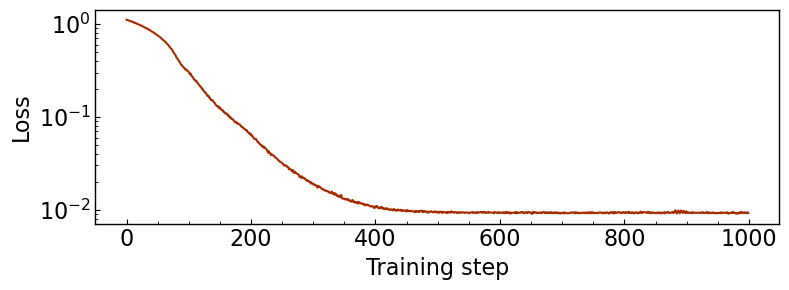

In [82]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(loss_history)
ax.set( yscale= 'log', ylabel='Loss', xlabel='Training step')
fig.tight_layout()
fig.savefig('loss_history.png')

## Sample generation

Finally, with the trained neural networks, we can generate new samples from the data distribution.

This process is very similar to the earlier diffusion process, except that here we start from a Normally-distributed $x_T$ and use the predicted mean and variance to gradually "remove" noise:

In [61]:
def sample_reverse(mean_model, var_model, count, sample=[0], steps=TIME_STEPS):
    p = torch.distributions.Normal(torch.zeros(count, 1), torch.ones(count, 1))
    xt = p.sample()
    if sample[0] != 0:
        xt = sample
    sample_history = [xt]
    for t in range(steps, 0, -1):
        xin = torch.cat((xt, t * torch.ones(xt.shape) / steps), dim=1)
        p = torch.distributions.Normal(
            mean_model(xin), var_model(xin)
        )
        xt = p.sample()
        sample_history.append(xt)
    return sample_history

In [100]:
np.arange(250,0,-50)

array([250, 200, 150, 100,  50])

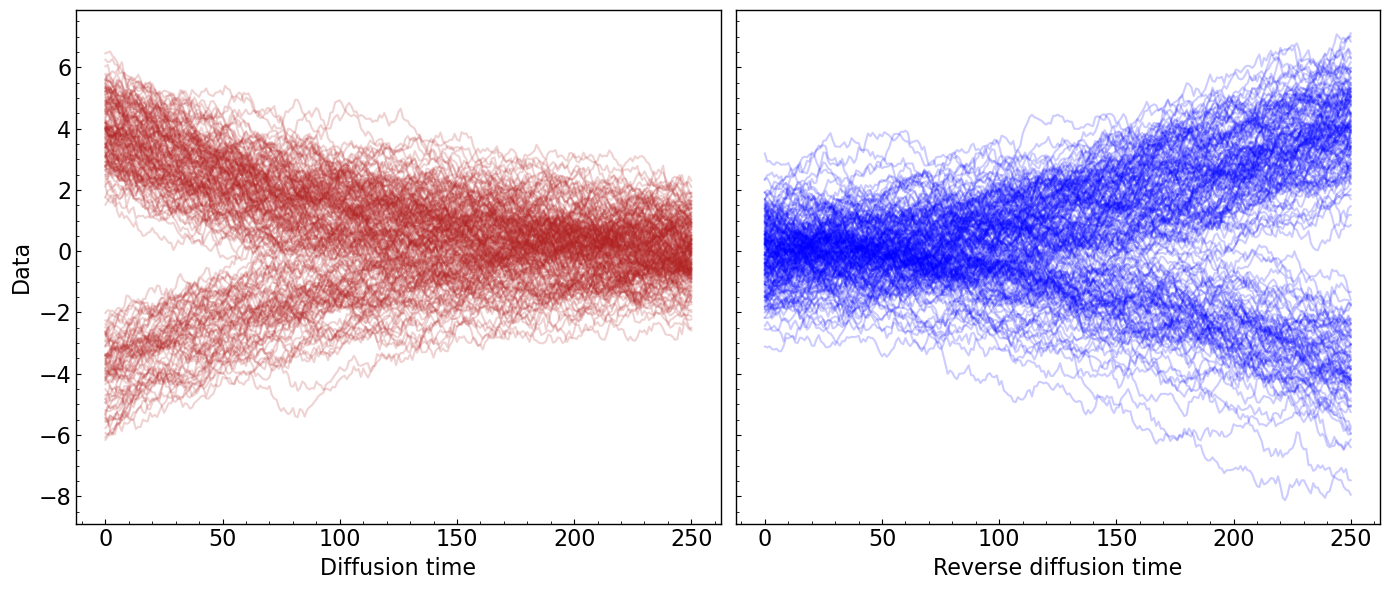

In [ ]:
samps = torch.stack(sample_reverse(mean_model, var_model, 1000, [0], steps=250))
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
for t in torch.stack(samples)[:, :, 0].T[:200]:
    ax[0].plot(t, c='firebrick', alpha=0.2)

for t in samps[:,:,0].T[:200]:
    ax[1].plot(t,color='blue', alpha=0.2)

ax[0].set( xlabel='Diffusion time', ylabel='Sample values')

ax[1].set( xlabel='Reverse diffusion time')
fig.tight_layout()
fig.savefig('1d_dif_samples.png', dpi=300)


And this is the distribution at the last step of generation:

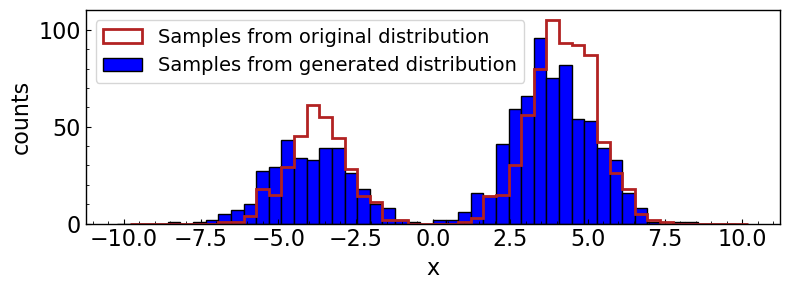

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
bins = np.linspace(-10, 10, 50)

ax.hist(dataset[:, 0], bins=bins,color='firebrick',lw=2,
         align='right', histtype='step',
         label='Samples from original distribution');

ax.hist(samps[-1, :, 0], bins,color='blue', 
        align='left', edgecolor='black',
        label='Samples from generated distribution')
ax.set(xlabel='x', ylabel='counts');
ax.legend()
fig.tight_layout()
fig.savefig('Generated_sample_comp.png')

It is very similar to the initial data distribution, which means that our model has successfully learned to generate samples resembling the training dataset!

I hope you found this tutorial useful! You can download a notebook with this code [here](/attachments/diffusion.ipynb).